In [2]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.datasets import load_iris

data = load_iris()
features = data.data
feature_names = data.feature_names
target = data.target
target_names = data.target_names

labels = target_names[target]

plength = features[:, 2]

is_setosa = (labels == 'setosa')
max_setosa = plength[is_setosa].max()
min_non_setosa = plength[~is_setosa].min()
# print('Maximum of setosa: {0}.'.format(max_setosa))
# print('Minimum of others: {0}.'.format(min_non_setosa))

features = features[~is_setosa]
labels = labels[~is_setosa]
is_virginica = (labels == 'virginica')

def fit_model(features, labels):
    best_acc = -1.0
    for fi in range(features.shape[1]):
        
        thresh = features[:, fi]
        for t in thresh:
            feature_i =  features[:, fi]
            pred = (feature_i > t)
            acc = (pred == labels).mean()
            rev_acc = (pred == ~labels).mean()
            if rev_acc > acc:
                reverse = True
                acc = rev_acc
            else:
                reverse = False
            if acc > best_acc:
                best_acc = acc
                best_fi = fi
                best_t = t
                best_reverse = reverse
    return best_t, best_fi, best_reverse

def predict(model, features):
    t, fi, reverse = model
    if reverse:
        return features[:, fi] <= t
    else:
        return features[:, fi] > t
    
correct = 0.0
for ei in range(len(features)):
    training = np.ones(len(features),bool)
    training[ei] = False
    testing = ~training
    model = fit_model(features[training], is_virginica[training])
    predictions = predict(model, features[testing])
    correct += np.sum(predictions == is_virginica[testing])
acc = correct/float(len(features))
print('Accuracy:{0:.1%}.'.format(acc))

Accuracy:87.0%.


In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import KFold

classifier = KNeighborsClassifier(n_neighbors = 1)

kf = KFold(len(features), n_folds=5, shuffle=True)

means = []
for training, testing in kf:
    classifier.fit(features[training], labels[training])
    prediction = classifier.predict(features[testing])
    curmean = np.mean(prediction == labels[testing])
    means.append(curmean)

print('Mean accuracy: {:.1%}'.format(np.mean(means)))

Mean accuracy: 93.0%


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

classifier = KNeighborsClassifier(n_neighbors = 1)
classifier = Pipeline([('norm', StandardScaler()), ('knn', classifier)])

kf = KFold(len(features), n_folds=5, shuffle=True)

means = []
for training, testing in kf:
    classifier.fit(features[training], labels[training])
    prediction = classifier.predict(features[testing])
    curmean = np.mean(prediction == labels[testing])
    means.append(curmean)

print('Mean accuracy: {:.1%}'.format(np.mean(means)))

Mean accuracy: 94.0%


In [6]:
import os
import sys
import scipy as sp
from sklearn.feature_extraction.text import CountVectorizer
import nltk.stem
english_stemmer = nltk.stem.SnowballStemmer('english')
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: (english_stemmer.stem(w) for w in analyzer(doc))
    

vectorizer = StemmedCountVectorizer(min_df=1, stop_words='english')
DIR = "/home/zym/learn/machine_learning/BuildingMachineLearningSystemsWithPython/ch03/data/toy"
posts = [open(os.path.join(DIR, f)).read() for f in os.listdir(DIR)]
X_train = vectorizer.fit_transform(posts)
num_samples, num_features = X_train.shape

# print("#samples: %d, #features: %d" % (num_samples, num_features))
# print(vectorizer.get_feature_names())

new_post = "imaging databases"
new_post_vec = vectorizer.transform([new_post])

def dist_raw(v1, v2):
    delta = v1 - v2
    return sp.linalg.norm(delta.toarray())

def dist_norm(v1, v2):
    v1_normalized = v1/sp.linalg.norm(v1.toarray())
    v2_normalized = v2/sp.linalg.norm(v2.toarray())
    delta = v1_normalized - v2_normalized
    return sp.linalg.norm(delta.toarray())

best_doc = None
best_dist = sys.maxsize
best_i = None
for i, post in enumerate(posts):
    if post == new_post:
        continue
    post_vec = X_train.getrow(i)
    d = dist_norm(post_vec, new_post_vec)
    print('=== Post %i with dist=%.2f: %s' % (i, d, post))
    if d < best_dist:
        best_dist = d
        best_i = i

print("Best post is %i with dist=%.2f" % (best_i, best_dist))




SyntaxError: invalid syntax (<ipython-input-6-3d88389e28e4>, line 10)

In [19]:
import os
import sys
import scipy as sp
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk.stem
english_stemmer = nltk.stem.SnowballStemmer('english')
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: (english_stemmer.stem(w) for w in analyzer(doc))

import sklearn.datasets
all_data = sklearn.datasets.fetch_20newsgroups(subset='all')
# print(len(all_data.filenames))

groups = ['comp.graphics', 'comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware', 
          'comp.sys.mac.hardware', 'comp.windows.x','sci.space']

train_data = sklearn.datasets.fetch_20newsgroups(subset='train', categories=groups)
test_data = sklearn.datasets.fetch_20newsgroups(subset='test', categories=groups)

# print(len(train_data.filenames))
# print(len(test_data.filenames))
vectorizer = StemmedTfidfVectorizer(min_df=10, max_df=0.5, stop_words='english', decode_error='ignore')
vectorized = vectorizer.fit_transform(train_data.data)
num_samples, num_features = vectorized.shape

print("#samples: %d, #features: %d" % (num_samples, num_features))

num_clusters = 50
from sklearn.cluster import KMeans
km = KMeans(n_clusters=num_clusters, init='random', n_init=1, verbose=1, random_state=3)
km.fit(vectorized)

new_post = """
Disk drive problems. Hi, I have a problem with my hard disk.
After 1 year it is working only sporadically now.
tried to format it, but now it doesn’t boot any more.
Any ideas? Thanks.
"""

new_post_vec = vectorizer.transform([new_post])
new_post_label = km.predict(new_post_vec)[0]

similar_indices = (km.labels_ == new_post_label).nonzero()[0]

similar = []
for i in similar_indices:
    dist = sp.linalg.norm((new_post_vec - vectorized[i]).toarray())
    similar.append((dist, train_data.data[i]))
    
similar = sorted(similar)
# print(len(similar))



#samples: 3529, #features: 4712
Initialization complete
Iteration  0, inertia 5899.560
Iteration  1, inertia 3218.298
Iteration  2, inertia 3184.333
Iteration  3, inertia 3164.867
Iteration  4, inertia 3152.004
Iteration  5, inertia 3143.111
Iteration  6, inertia 3136.256
Iteration  7, inertia 3129.325
Iteration  8, inertia 3124.567
Iteration  9, inertia 3121.900
Iteration 10, inertia 3120.210
Iteration 11, inertia 3118.627
Iteration 12, inertia 3117.363
Iteration 13, inertia 3116.811
Iteration 14, inertia 3116.588
Iteration 15, inertia 3116.417
Iteration 16, inertia 3115.760
Iteration 17, inertia 3115.374
Iteration 18, inertia 3115.155
Iteration 19, inertia 3114.949
Iteration 20, inertia 3114.515
Iteration 21, inertia 3113.937
Iteration 22, inertia 3113.720
Iteration 23, inertia 3113.548
Iteration 24, inertia 3113.475
Iteration 25, inertia 3113.447
Converged at iteration 25
['ac', 'birmingham', 'host', 'kingdom', 'nntp', 'sorri', 'test', 'uk', 'unit', 'univers']


In [20]:
post_group = zip(train_data.data, train_data.target)
all = [(len(post[0]), post[0], train_data.target_names[post[1]]) for post in post_group]

graphics = sorted([post for post in all if post[2] == 'comp.graphics'])
# print(graphics[5])

noise_post = graphics[5][1]
analyzer = vectorizer.build_analyzer()
# print(list(analyzer(noise_post)))
useful = set(analyzer(noise_post)).intersection(vectorizer.get_feature_names())

print(sorted(useful))

['ac', 'birmingham', 'host', 'kingdom', 'nntp', 'sorri', 'test', 'uk', 'unit', 'univers']


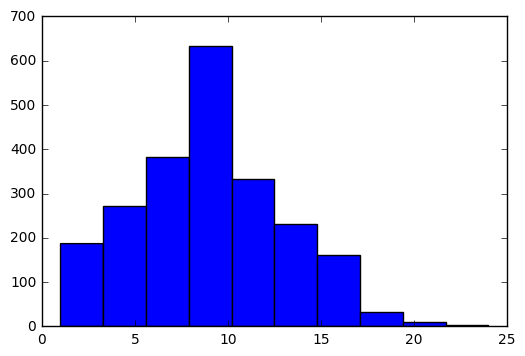

In [23]:
import os
from matplotlib import pyplot as plt
from gensim import corpora, models
DIR = '/home/zym/learn/machine_learning/BuildingMachineLearningSystemsWithPython/ch04/ap'
corpus = corpora.BleiCorpus(os.path.join(DIR, 'ap.dat'), os.path.join(DIR, 'vocab.txt'))

model = models.ldamodel.LdaModel(corpus, num_topics=100,id2word=corpus.id2word)
doc = corpus.docbyoffset(0)
topics = model[doc]
# print(topics)

num_topics_used = [len(model[doc]) for doc in corpus]
plt.hist(num_topics_used)
plt.show()

In [11]:
from __future__ import print_function
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000
n_features = 1000
n_topics = 10
n_top_words = 20

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx)
        print(" ".join([feature_names[i]
                      for i in topic.argsort()[:-n_top_words - 1: -1]]))
    print()
    
dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                            remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data[:n_samples]
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                  max_features=n_features,
                                  stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data_samples)


lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

lda.fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(lda, tfidf_feature_names, n_top_words)


Topic #0: 
windows thanks file edu use drive software mail help does card pc know hi using need program problem looking window
Topic #1: 
dog attack head drive talking human maybe disk printer drivers window problem mac advance thanks use hard work ii windows
Topic #2: 
god accept read clock driving stuff nature port think error hard usually 60 computer faith know following limited peter control
Topic #3: 
pp 22 18 19 11 23 26 55 van 10 31 44 27 21 38 34 48 24 armenian 37
Topic #4: 
2nd math ground value said leafs display long try lunar launch monitor space version shuttle luck computer door probe moon
Topic #5: 
cases 00 soon edu sale condition effective asking consider good general john stuff nhl card san cd deleted end hear
Topic #6: 
mike love graphics hear heard try state time looking good performance windows marriage os crime company parts program comp men
Topic #7: 
assume magi home order card right lot supposed hit better thing especially week record require use ground importa

In [88]:
import os
import json
import numpy as np
from sklearn import neighbors
from sklearn.cross_validation import KFold

def extract_features_from_meta(v):
    num_text_tokens = v['NumTextTokens']
    num_code_lines = v['NumCodeLines']
    link_count = v['LinkCount']
    return num_text_tokens, num_code_lines, link_count

DIR = '/home/zym/learn/machine_learning/BuildingMachineLearningSystemsWithPython/ch05/data'

        
with open(os.path.join(DIR,'chosen-meta.json'), 'r') as data_file:
    meta = json.load(data_file)

all_answers = [int(post_id) for post_id, v in meta.items() if v['ParentId'] != -1]

Y = np.asarray([meta[str(answerId)]['Score'] > 0 for answerId in all_answers])
Y = Y.reshape(len(Y),1)

X = np.asarray([extract_features_from_meta(v) for post_id, v in meta.items() if int(post_id) in all_answers])

clf = neighbors.KNeighborsClassifier()
cv = KFold(n=len(X), n_folds=10, shuffle=True)
scores = []

for train, test in cv:
    x_train, y_train = X[train], Y[train]
    x_test, y_test = X[test], Y[test]
    clf.fit(x_train, y_train)
    scores.append(clf.score(x_test, y_test))
    
print("Mean(scores)=%.5f\tStddev(scores)=%.5f" % (np.mean(scores), np.std(scores)))

Mean(scores)=0.51190	Stddev(scores)=0.10116


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:40: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [15]:
import os
import json
import numpy as np

from sklearn import linear_model

from sklearn.cross_validation import KFold

def extract_features_from_meta(v):
    num_text_tokens = v['NumTextTokens']
    num_code_lines = v['NumCodeLines']
    link_count = v['LinkCount']
    return num_text_tokens, num_code_lines, link_count

DIR = '/Users/zhu/Documents/learning/machine_learing/BuildingMachineLearningSystemsWithPython/ch05/data'

        
with open(os.path.join(DIR,'chosen-meta.json'), 'r') as data_file:
    meta = json.load(data_file)

all_answers = [int(post_id) for post_id, v in meta.items() if v['ParentId'] != -1]

Y = np.asarray([meta[str(answerId)]['Score'] > 0 for answerId in all_answers])
# Y = Y.reshape(len(Y),1)

X = np.asarray([extract_features_from_meta(v) for post_id, v in meta.items() if int(post_id) in all_answers])
# print(X.shape)

logistic = linear_model.LogisticRegression()
cv = KFold(n=len(X), n_folds=10, shuffle=True)
scores = []
for train, test in cv:
    X_train = X[train]
    Y_train = Y[train]
    X_test = X[test]
    Y_test = Y[test]
    logistic.fit(X_train, Y_train)
    scores.append(logistic.score(X_test, Y_test))

print('LogisticRegression score: %f\tstddev: %f' % (np.mean(scores), np.std(scores)))

LogisticRegression score: 0.708197	stddev: 0.059920


In [16]:
import numpy as np

from sklearn import datasets, linear_model

from sklearn.cross_validation import KFold

digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

logistic = linear_model.LogisticRegression()
cv = KFold(n=len(X_digits), n_folds=10, shuffle=True)
scores = []
for train, test in cv:
    X_train = X_digits[train]
    y_train = y_digits[train]
    X_test = X_digits[test]
    y_test = y_digits[test]
    logistic.fit(X_train, y_train)
    scores.append(logistic.score(X_test, y_test))

print('LogisticRegression score: %f\tstddev: %f' % (np.mean(scores), np.std(scores)))

LogisticRegression score: 0.961040	stddev: 0.008279


In [52]:
import numpy as np

# download data from this site https://github.com/aweiand/TwitterSentiment
# delete two json file 126131070050639874 126111632773480448
import sys
sys.path.insert(0, '/home/zym/learn/machine_learning/BuildingMachineLearningSystemsWithPython/ch06')

from utils import load_sanders_data

X, Y = load_sanders_data()

classes = np.unique(Y)
for c in classes: print("#%s: %i" % (c, sum(Y==c)))

pos_neg_idx = np.logical_or(Y=="positive", Y=="negative")
X = X[pos_neg_idx]
Y = Y[pos_neg_idx]
Y = Y == 'positive'

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

def create_ngram_model():
    tfidf_ngrams = TfidfVectorizer(ngram_range=(1, 3), analyzer="word", binary=False)
    clf = MultinomialNB()
    return Pipeline([('vect', tfidf_ngrams), ('clf', clf)])

from sklearn.metrics import precision_recall_curve, auc
from sklearn.cross_validation import ShuffleSplit

def train_model(clf_factory, X, Y):
    cv = ShuffleSplit(n=len(X), n_iter=10, test_size=0.3, random_state=0)
    
    scores=[]
    pr_scores=[]
    
    for train, test in cv:
        X_train, y_train = X[train], Y[train]
        X_test, y_test = X[test], Y[test]
        
        clf = clf_factory()
        clf.fit(X_train, y_train)
        
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        
        scores.append(test_score)
        proba = clf.predict_proba(X_test)
        
        precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:, 1])
        pr_scores.append(auc(recall, precision))
        
    summary = (np.mean(scores), np.std(scores), np.mean(pr_scores), np.std(pr_scores))

    print('%.3f\t%.3f\t%.3f\t%.3f' % summary)

train_model(create_ngram_model, X, Y)


#irrelevant: 95
#negative: 288
#neutral: 609
#positive: 194
0.731	0.029	0.888	0.033


In [54]:
import numpy as np

# download data from this site https://github.com/aweiand/TwitterSentiment
# delete two json file 126131070050639874 126111632773480448
import sys
sys.path.insert(0, '/home/zym/learn/machine_learning/BuildingMachineLearningSystemsWithPython/ch06')

from utils import load_sanders_data

X, Y = load_sanders_data()

classes = np.unique(Y)
for c in classes: print("#%s: %i" % (c, sum(Y==c)))
    
def tweak_labels(Y, pos_sent_list):
    pos = Y == pos_sent_list[0]
    for sent_label in pos_sent_list[1:]:
        pos |= Y == sent_label
    Y = np.zeros(Y.shape[0])
    Y[pos] = 1
    Y = Y.astype(int)
    return Y

Y = tweak_labels(Y, ['positive', 'negative'])

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

def create_ngram_model():
    tfidf_ngrams = TfidfVectorizer(ngram_range=(1, 3), analyzer="word", binary=False)
    clf = MultinomialNB()
    return Pipeline([('vect', tfidf_ngrams), ('clf', clf)])

from sklearn.metrics import precision_recall_curve, auc
from sklearn.cross_validation import ShuffleSplit

def train_model(clf_factory, X, Y):
    cv = ShuffleSplit(n=len(X), n_iter=10, test_size=0.3, random_state=0)
    
    scores=[]
    pr_scores=[]
    
    for train, test in cv:
        X_train, y_train = X[train], Y[train]
        X_test, y_test = X[test], Y[test]
        
        clf = clf_factory()
        clf.fit(X_train, y_train)
        
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        
        scores.append(test_score)
        proba = clf.predict_proba(X_test)
        
        precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:, 1])
        pr_scores.append(auc(recall, precision))
        
    summary = (np.mean(scores), np.std(scores), np.mean(pr_scores), np.std(pr_scores))

    print('%.3f\t%.3f\t%.3f\t%.3f' % summary)

train_model(create_ngram_model, X, Y)

#irrelevant: 95
#negative: 288
#neutral: 609
#positive: 194
0.746	0.018	0.798	0.031


In [59]:
import re
import numpy as np

# download data from this site https://github.com/aweiand/TwitterSentiment
# delete two json file 126131070050639874 126111632773480448
import sys
sys.path.insert(0, '/home/zym/learn/machine_learning/BuildingMachineLearningSystemsWithPython/ch06')

from utils import load_sanders_data

X, Y = load_sanders_data()

classes = np.unique(Y)
for c in classes: print("#%s: %i" % (c, sum(Y==c)))
    
def tweak_labels(Y, pos_sent_list):
    pos = Y == pos_sent_list[0]
    for sent_label in pos_sent_list[1:]:
        pos |= Y == sent_label
    Y = np.zeros(Y.shape[0])
    Y[pos] = 1
    Y = Y.astype(int)
    return Y

Y = tweak_labels(Y, ['positive', 'negative'])

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

emo_repl = {
    # positive emoticons
    "&lt;3": " good ",
    ":d": " good ", # :D in lower case
    ":dd": " good ", # :DD in lower case
    "8)": " good ",
    ":-)": " good ",
    ":)": " good ",
    ";)": " good ",
    "(-:": " good ",
    "(:": " good ",
    # negative emoticons:
    ":/": " bad ",
    ":&gt;": " sad ",
    ":')": " sad ",
    ":-(": " bad ",
    ":(": " bad ",
    ":S": " bad ",
    ":-S": " bad ",
}

emo_repl_order = [k for (k_len, k) in reversed(sorted([(len(k), k) for k in emo_repl.keys()]))]

re_repl = {
    r"\br\b": "are",
    r"\bu\b": "you",
    r"\bhaha\b": "ha",
    r"\bhahaha\b": "ha",
    r"\bdon't\b": "do not",
    r"\bdoesn't\b": "does not",
    r"\bdidn't\b": "did not",
    r"\bhasn't\b": "has not",
    r"\bhaven't\b": "have not",
    r"\bhadn't\b": "had not",
    r"\bwon't\b": "will not",
    r"\bwouldn't\b": "would not",
    r"\bcan't\b": "can not",
    r"\bcannot\b": "can not",
}

def create_ngram_model():
    def preprocessor(tweet):
        tweet = tweet.lower()
        for k in emo_repl_order:
            tweet = tweet.replace(k, emo_repl[k])
        for r, repl in re_repl.items():
            tweet = re.sub(r, repl, tweet)
        return tweet
    
    tfidf_ngrams = TfidfVectorizer(preprocessor=preprocessor, analyzer="word", binary=False)
    clf = MultinomialNB()
    return Pipeline([('vect', tfidf_ngrams), ('clf', clf)])

from sklearn.metrics import precision_recall_curve, auc
from sklearn.cross_validation import ShuffleSplit

def train_model(clf_factory, X, Y):
    cv = ShuffleSplit(n=len(X), n_iter=10, test_size=0.3, random_state=0)
    
    scores=[]
    pr_scores=[]
    
    for train, test in cv:
        X_train, y_train = X[train], Y[train]
        X_test, y_test = X[test], Y[test]
        
        clf = clf_factory()
        clf.fit(X_train, y_train)
        
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        
        scores.append(test_score)
        proba = clf.predict_proba(X_test)
        
        precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:, 1])
        pr_scores.append(auc(recall, precision))
        
    summary = (np.mean(scores), np.std(scores), np.mean(pr_scores), np.std(pr_scores))

    print('%.3f\t%.3f\t%.3f\t%.3f' % summary)

train_model(create_ngram_model, X, Y)


#irrelevant: 95
#negative: 288
#neutral: 609
#positive: 194
0.767	0.016	0.780	0.032


In [1]:
import nltk

# download ptb treebank punkt averaged_perceptron_tagger maxent_treebank_pos_tagger

import csv, collections

DATA_DIR = ''

def load_sent_word_net():
    sent_scores = collections.defaultdict(list)
    
    with open(os.path.join(DATA_DIR, 'SentiWordNet_3.0.0_20130122.txt'), 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter='\t', quotechar='"')
        for line in reader:
            if line[0].startswith('#'):
                continue
            if len(line)==1:
                continue
            POS, ID, PosScore, NegScore, SynsetTerms, Gloss = line
            if len(POS)==0 or len(ID)==0:
                continue
            for term in SynsetTerms.split(' '):
                term = term.split('#')[0]
                term = term.replace('-', ' ').replace('_', ' ')
                key = '%s%s' % (POS, term.split('#')[0])
                sent_scores[key].append((float(PosScore), float(NegScore)))
                
    for key, value in sent_scores.items():             
        sent_scores[key] = np.mean(value, axis=0)
        
    return sent_scores

nltk.pos_tag(nltk.word_tokenize('This is a good book.'))

[('This', 'DT'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('good', 'JJ'),
 ('book', 'NN'),
 ('.', '.')]

In [19]:
import numpy as np

from sklearn.datasets import load_boston
boston = load_boston()

# from matplotlib import pyplot as plt
# plt.scatter(boston.data[:,5], boston.target, color='r')
# plt.show()

from sklearn.linear_model import LinearRegression

lr = LinearRegression()

# x = boston.data[:, 5]
# x = np.transpose(np.atleast_2d(x))
x = boston.data
y = boston.target

lr.fit(x, y)

y_predicted = lr.predict(x)

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y, y_predicted)
print("Mean squared error (of training data): {:.3}".format(mse))

rmse = np.sqrt(mse)
print("RMSE (of training data): {:.3}".format(rmse))

from sklearn.metrics import r2_score
r2 = r2_score(y, y_predicted)
print("R2 (on training data): {:.2}".format(r2))

Mean squared error (of training data): 21.9
RMSE (of training data): 4.68
R2 (on training data): 0.74


In [21]:
import numpy as np

from sklearn.datasets import load_boston
boston = load_boston()

from sklearn.linear_model import LinearRegression

lr = LinearRegression()

x = boston.data
y = boston.target

from sklearn.cross_validation import KFold

kf = KFold(len(x), n_folds=5)
p = np.zeros_like(y)
for train, test in kf:
    lr.fit(x[train], y[train])
    p[test]=lr.predict(x[test])
rmse_cv = np.sqrt(mean_squared_error(p, y))
print('RMSE on 5-fold CV: {:.2}'.format(rmse_cv))

RMSE on 5-fold CV: 6.1


In [24]:
import numpy as np

from sklearn.datasets import load_boston
boston = load_boston()

# from matplotlib import pyplot as plt
# plt.scatter(boston.data[:,5], boston.target, color='r')
# plt.show()

from sklearn.linear_model import ElasticNet

en = ElasticNet(alpha=0.5)

# x = boston.data[:, 5]
# x = np.transpose(np.atleast_2d(x))
x = boston.data
y = boston.target

en.fit(x, y)

y_predicted = en.predict(x)

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y, y_predicted)
print("Mean squared error (of training data): {:.3}".format(mse))

rmse = np.sqrt(mse)
print("RMSE (of training data): {:.3}".format(rmse))

from sklearn.metrics import r2_score
r2 = r2_score(y, y_predicted)
print("R2 (on training data): {:.2}".format(r2))

Mean squared error (of training data): 24.9
RMSE (of training data): 4.99
R2 (on training data): 0.71


In [25]:
import numpy as np

from sklearn.datasets import load_boston
boston = load_boston()

from sklearn.linear_model import ElasticNet

en = ElasticNet(alpha=0.5)

x = boston.data
y = boston.target

from sklearn.cross_validation import KFold

kf = KFold(len(x), n_folds=5)
p = np.zeros_like(y)
for train, test in kf:
    en.fit(x[train], y[train])
    p[test]=en.predict(x[test])
rmse_cv = np.sqrt(mean_squared_error(p, y))
print('RMSE on 5-fold CV: {:.2}'.format(rmse_cv))

RMSE on 5-fold CV: 5.6


In [28]:
from sklearn.datasets import load_svmlight_file
# download file here https://github.com/samuelcs/ml_libs/tree/master/data
data, target = load_svmlight_file('data/E2006.train')

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(data, target)
pred = lr.predict(data)
rmse_train = np.sqrt(mean_squared_error(target, pred))
print('RMSE on training: {:.2}'.format(rmse_train))


Min target value: -7.89957807346873


In [ ]:
from sklearn.datasets import load_svmlight_file
data, target = load_svmlight_file('data/E2006.train')

import numpy as np

from sklearn.linear_model import LinearRegression
lr = LinearRegression()

from sklearn.cross_validation import KFold

kf = KFold(len(target), n_folds=5)

pred = np.zeros_like(target)

for train, test in kf:
    lr.fit(data[train], target[train])
    pred[test]=lr.predict(data[test])
rmse = np.sqrt(mean_squared_error(target, pred))
print('[EN 0.1] RMSE on testing (5 fold): {:.2}'.format(rmse))

from sklearn.metrics import r2_score
r2 = r2_score(target, pred)
print('[EN 0.1] R2 on testing (5 fold): {:.2}'.format(r2))

In [39]:
from sklearn.datasets import load_svmlight_file
data, target = load_svmlight_file('data/E2006.train')

import numpy as np

from sklearn.linear_model import ElasticNet

met = ElasticNet(alpha=0.1)

from sklearn.cross_validation import KFold

kf = KFold(len(target), n_folds=5)

pred = np.zeros_like(target)

for train, test in kf:
    met.fit(data[train], target[train])
    pred[test]=met.predict(data[test])
rmse = np.sqrt(mean_squared_error(target, pred))
print('[EN 0.1] RMSE on testing (5 fold): {:.2}'.format(rmse))

from sklearn.metrics import r2_score
r2 = r2_score(target, pred)
print('[EN 0.1] R2 on testing (5 fold): {:.2}'.format(r2))

[EN 0.1] RMSE on testing (5 fold): 0.4
[EN 0.1] R2 on testing (5 fold): 0.61
